## The Most Dangerous Equation

In his famous article of 2007, Howard Wainer writes about very dangerous equations:


"Some equations  are  dangerous  if you  know them, and others are dangerous if you do not. The first category may  pose  danger  because the secrets  within its bounds open  doors  behind which lies terrible peril. The obvious winner in this is Einstein’s iconic equation \\(E = MC^2\\), for it  provides  a  measure of  the  enormous energy hidden  within  ordinary  matter. \[...\] Instead I am interested in equations that unleash their danger not when we know about them, but rather when we do not. Kept close at hand, these equations allow us to understand things clearly, but their absence leaves us dangerously ignorant."

The equation he talks about is the Moivre’s equation:

$
SE = \dfrac{\sigma}{\sqrt{n}} 
$

where \\(SE\\) is the standard error of the mean, \\(\sigma\\) is the standard deviation and \\(n\\) is the sample size.

To see why not knowing this equation is very dangerous, let's take a look at some education data. I've compiled data on ENEM score (Brazilian standardised high school score, similar to SAT) from different schools for a period 3 years. I also did some cleaning on the data to keep only the information relevant to us. The original data can be downloaded in the [Inep website](http://portal.inep.gov.br/web/guest/microdados#).

If we look at the top performing school, something catches the eye: those schools have a fairly small number of students. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")


df = pd.read_csv("./data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

In /Users/matheus.facure/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/matheus.facure/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/matheus.facure/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/matheus.facure/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/matheus.facure/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


Indeed, if we look at to 1% schools, we figure out they have, on average, a smaller number of students. 

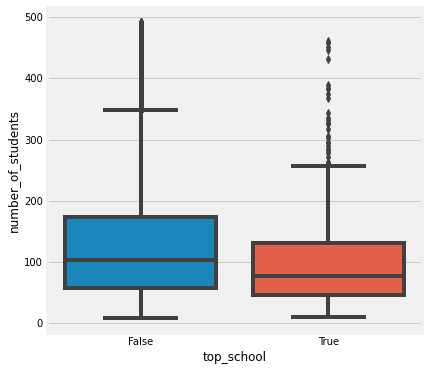

In [2]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}") # remove outliers
            )

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data);

But why exactly is the dangerous? Well, it becomes dangerous once people start to make important and expensive decisions based on this information. In his article, Howard continues:

"In the 1990s, it became popular to champion reductions in the size of schools. Numerous philanthropic organisations and government agencies funded the division of larger school based on the fact that students at small schools are over represented in groups with high test scores."

What people forgot to do was to look also at the bottom 1% of schools. If we do that, lo and behold! They also have very few students!

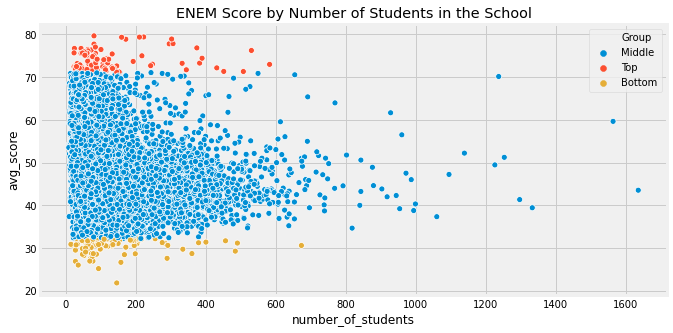

In [3]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

What we are seeing above is exactly what's is expected according to the Moivre’s equation. This beautiful triangular plot shows how average score has a huge variance with small sample sizes. It also shows that variance shrinks as the sample size increases.

##  The Standard Error of Our Estimates

In the previous section, we estimated the average treatment effect \\(E[Y_1-Y_0]\\) as the difference in the means between the treated and the untreated \\(E[Y|T=1]-E[Y|T=0]\\). As our motivating example, we figured out the \\(ATE\\) for online classes. We also saw that it was a negative impact, that is, online classes made students perform about 5 points worse than the students with face to face classes. Now, we get to see if they are statistically significant.

To do so, we need to estimate \\(SE\\). We already have \\(n\\), our sample size. To get the estimate for the standard deviation we can do the following

$
\hat{\sigma}=\frac{1}{N-1}\sum_{i=0}^N (x-\bar{x})^2
$

where \\(\bar{x}\\) is the mean of \\(x\\). Fortunately for us, most programming software already implement this. in Pandas, we can use the method [std](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html).

In [4]:
data = pd.read_csv("./data/tablets_in_the_classroom.csv")
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319106


## Confidence Intervals

The standard error of our estimate is a mesure of confidence. To understand exactly what it means, we need to go into turbulent and polemic statistical waters. For one view of statistics, the frequentist view, we would say that the data we have is nothing more than a manifestation of a true data generating process. This process is abstract and ideal. It is governed by true parameters that are unchanging but unknown to us. In the context of the students test, if we could run multiple experiments and collect multiple datasets, all would reusable the true underlying data generating process, but wound't be exactly like it. This is very much alike Plato's writing on the Forms:

```
Each [of the essential forms] manifests itself in a great variety of combinations, with actions, with material things, and with one another, and each seems to be many
```

To better grasp this, let's suppose we have a true abstract distribution of students' test score. This is a normal distribution with true mean of 74 and true standard deviation of 2. From this distribution, we run 10000 experiments. On each one, we collect 500 samples. Some experiment data will have a mean lower than the true one, some will be higher. If we plot them in a histogram, we can see that the true mean is where most of the experiments' mean fall in. 

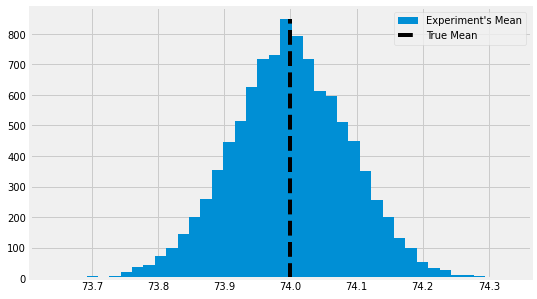

In [5]:
true_std = 2
true_mean = 74

n = 500
def run_experiment(): 
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment's Mean")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean")
plt.legend();


So by, chance, we could have an experiment where the mean is somewhat bellow or above the true mean. This is to say that we can never be sure that the mean of our experiment matches the true platonic and ideal mean. However, **with the standard error, we can create an interval that will contain the true mean 95% of the time**. This is what we call the confidence interval. We use what is called the **central limit theorem** to do that. This theorem states that **means of experiments are normally distributed**. From statistical theory, we know that 95% of the mass of a normal distribution is between 2 standard deviations above and bellow the mean. Technically, 1.96, but 2 is close enough. 

![normal_density](./data/img/normal_dist.jpeg)

The Standard Error of the mean serves as our estimate for the means' distribution of our experiments. So, if we multiply it by 2 and add and subtract it from one of our experiment's mean, we will construct an interval that contains the true population average 95% of the time.

In [6]:
np.random.seed(321)
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print(ci)

(73.82718114045632, 74.17341543460314)


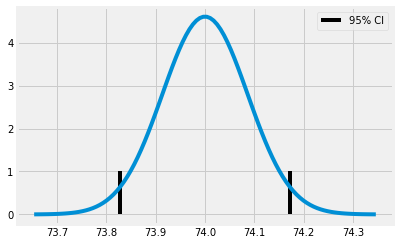

In [7]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

Of course, we don't need to restrict ourself to the 95% confidence interval. We could generate the 99% interval by finding how many times do we need to multiply the standard deviation so the interval contains 99% of the mass of a normal distribution. 

The function `ppf` in python gives us the inverse of the CDF. So, `ppf(0.5)` will return 0.0, saying that 50% of the mass of the standard normal distribution is bellow 0.0. By the same token, if we plug 99.5%, we will have the value `z`, such that 99.5% of the distribution mass falls bellow this value. In other words, 0.05% of the mass falls above this value. We will take this value from above and bellow the distribution, which will result that 99% if the distribution falls between them. Here is the 99% interval.

In [8]:
from scipy import stats
z = stats.norm.ppf(.995)
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(73.7773381773405, 74.22325839771896)

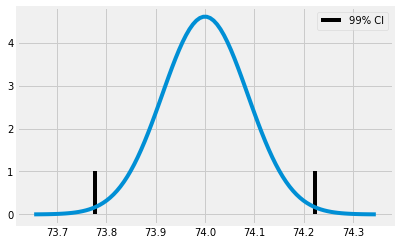

In [9]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="99% CI")
plt.legend()
plt.show()

Back to our classroom experiment, we can construct the confidence interval for the mean exam score for both the online and face to face students' group

In [10]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% for Face to Face: (76.80278229206951, 80.29218687459715)


What we can see is that the 95% CI of the groups don't overlap. The lower end of the CI for Face to Face class is above the upper end of the CI for online classes. This is evidence that our result is not by chance. There is a significant, causal decrease in academic performance once you switch from face to face to online classes.

## Hypothesis Testing

Another way to figure this out is to state a hypothesis test: is the difference in mean statistically different from zero? To do so, we will recall that the sum or difference of 2 normal distribution is also a normal distribution. The resulting mean will be the sum of difference between the two distribution, while the variance will always be the sum of the variance:

$
N(\mu_1, \sigma_1^2) - N(\mu_2, \sigma_2^2) = N(\mu_1 - \mu_2, \sigma_1^2 + \sigma_2^2)
$

$
N(\mu_1, \sigma_1^2) + N(\mu_2, \sigma_2^2) = N(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)
$

If you don't recall, its OK. We can always use code and simulated data to check:

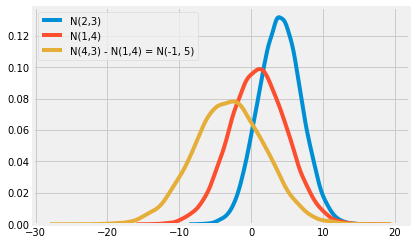

In [11]:
np.random.seed(123)
n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1
sns.distplot(n1, hist=False, label="N(2,3)")
sns.distplot(n2, hist=False, label="N(1,4)")
sns.distplot(n_diff, hist=False, label=f"N(4,3) - N(1,4) = N(-1, 5)")
plt.show()

So, if we take the distribution of the means of our 2 groups and subtract one from the other, we will have a third distribution. The mean of this final distribution will be the difference in the means and the standard deviation of this distribution will be the square root of the sum of the standard deviations.

$
\mu_{diff} = \mu_1 + \mu_2
$

$
SE_{diff} = \sqrt{SE_1 + SE_2} = \sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}
$

Let's return the our classroom example. We will construct this distribution of the diference. Of course that, once we have it, building the 95% CI is very easy.

In [12]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(-8.376410208363385, -1.4480327880905248)


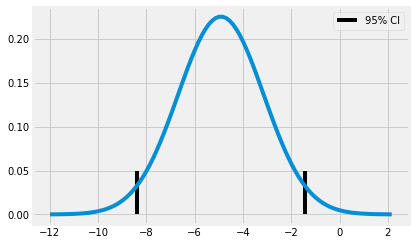

In [13]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

With this at hand, we can say that the true difference between the online and face to face group falls between -8.37 and -1.44. We can also construct a **z statistic** by dividing the difference in mean by the \\(SE\\) of the differences. 

$
z = \dfrac{\mu_{diff} - H_{0}}{SE_{diff}} = \dfrac{(\mu_1 - \mu_2) - H_{0}}{\sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}}
$

Where \\(H_0\\) is the value which we want to test our difference against.

The z statistic is a mesure of how extreme the observed difference is. To test our hypothesis that the difference in the means is statistically different from zero, we will use contradiction. We will assume that the opposite is true, that it, we will assume that the difference is zero. This is calls a null hypothesis, or \\(H_0\\). Then, we will ask ourselves "is it likely that we would observe such a difference if the true difference where zero?" In statistical math terms, we can translate this question to checking how far from zero is our z statistic. 

Under \\(H_0\\), the z statistic follows a normal standard normal distribution. So, if the difference is indeed zero, we would see the z statistic between 2 standard deviation of the mean 95% of the time. The direct consequence of this is that if z falls above of bellow 2 standard deviations (which, by the way, is 1 for the standard normal), we can reject the null hypothesis with 95% confidence.

Let's see how this looks like in our classroom example.

In [14]:
z = diff_mu / diff_se
print(z)

-2.7792810791031224


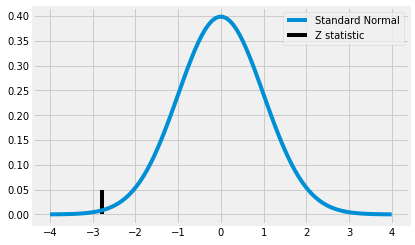

In [15]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic")
plt.legend()
plt.show()

This looks like a pretty extreme value. Indeed, it is above 2, which means there is less than 95% chance that we would see such an extreme value if the there where no difference in the groups. This again lead us to conclude that switching from face to face to online classes causes a statistically significant drop in academic performance.

## P-values

I've said previously that there is less than 95% chance that we would observe such an extreme value is the difference between online and face to face groups where actually zero. But can we estimate exacly what is that chance? How likly are we to observe such an extreme value? Enters P-Values!

The true definition of P-values can be very confusing (the same is true for most frequentist statistics). So, to not take any risks, I'll copy the definition in Wikipedia: "the p-value is the probability of obtaining test results at least as extreme as the results actually observed during the test, assuming that the null hypothesis is correct". Don't let this complexity fools you. In practicle terms, they are prety straightforeward to use.

![p_value](./data/img/p_value.png)

To get the p-value, we need to compute the area under the standard normal distribution before or after the z statistic. Fortunalty, we have a computer to do this calculation for us. We can simply plug the z statistic in the CDF of the standard normal distribution.

In [16]:
print("P-value:", stats.norm.cdf(z))

P-value: 0.0027239680835563383


This means that there is only 0.2% chance of observing this extreme z statistic if the difference was zero. Not how the P-value is interesting because it avoids us having to specify a confidence level, like 95% or 99%. But, if we wish to report one, from the p-value, we know exactly which confidence will our test pass or fail. For instance, with a p-value of 0.0027, we know that we have significance up to the 0.2% level. So, while the 95% CI for the difference and the 99% CI will neither contain zero, the 99.9% CI will. 

In [17]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
print("95% CI:", (diff_mu - stats.norm.ppf(.975)*diff_se, diff_mu + stats.norm.ppf(.975)*diff_se))
print("99% CI:", (diff_mu - stats.norm.ppf(.995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))
print("99.9% CI:", (diff_mu - stats.norm.ppf(.9995)*diff_se, diff_mu + stats.norm.ppf(.9995)*diff_se))

95% CI: (-8.376346553082909, -1.4480964433710017)
99% CI: (-9.46485353526404, -0.3595894611898709)
99.9% CI: (-10.728040658245558, 0.9035976617916459)


## Wrapping Up and Keys Ideas

We've saw how important it is no know the Moivre’s equation and we used it to place a degree of certainty around our estimates. Namely, we figured out that the online classes cause a decrease in academic performance compared to face to face classes. We also saw that this was a statistically significant result. We did it by comparing the Confidence Intervals of the means for the 2 groups, by looking at the confidence interval for the difference, by doing a hypothesis test and by looking at the p-value. Let's wrap everything up in a single function that does A/B testing comparison like the one we did above

In [18]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)
    
    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)
    
    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")
        
AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.7792810791031224
P-Value 0.0027239680835563383


Since our function is generic enough, we can test other null hypothesis. For instance, can we try to reject that the difference between online and face to face class performance is -1. With the results we get, we can say with 95% confidence that the difference is greater than -1. But we can't say it with 99% confidence.

In [19]:
AB_test(online, face_to_face, h0=-1)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.2134920404560883
P-Value 0.013431870694630114


## References

I like to think of this entire series is a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this though year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

In this particular section, I've also referenced The [Most Dangerous Equation](https://www.researchgate.net/publication/255612702_The_Most_Dangerous_Equation), by Howard Wainer.